In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
from multiprocessing import Pool
from tqdm import tqdm
import pickle

In [2]:
data = pd.read_csv("gen_data.csv")
data

,Unnamed: 0,cue,pressed,outcome,ID
0,0,1,1,1,0
1,1,1,1,1,0
2,2,2,0,-1,0
3,3,2,1,0,0
4,4,1,1,1,0
...,...,...,...,...,...
5995,595,4,0,-1,9
5996,596,3,0,1,9
5997,597,2,1,0,9
5998,598,4,1,-1,9


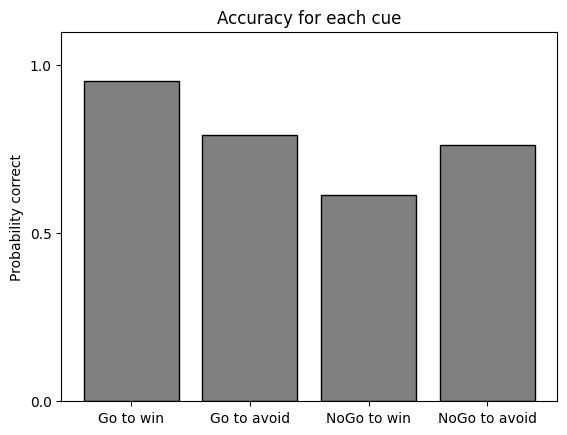

In [53]:
cue_mapping = {1: 'Go to win', 2: 'Go to avoid', 3: 'NoGo to win', 4: 'NoGo to avoid'}  # Go+ = Go to win, Go- = go to avoid losing, NoGo+ = don't go to win, NoGo- = don't go to avoid losing

cue_correct_response_map = {1: 1, 2: 1, 3: 0, 4: 0} # 1 = go, 0 = no go 
# exercise 1: plot the accuracy for each cue
accuracies = {}
for cue in cue_mapping:
    n = data[data["cue"] == cue].shape[0]
    accuracies[cue_mapping[cue]] = np.logical_and(data["cue"] == cue, data["pressed"] == cue_correct_response_map[cue]).sum() / n;
    
# plot a historam of accuracies with y-axis labeled "probability correct" and x-axis with the cue names from cue_mapping
plt.bar(accuracies.keys(), accuracies.values(), align="center", color="gray", edgecolor="black");
plt.ylabel("Probability correct")
plt.title("Accuracy for each cue")
# determing the y-axis limits and each possible value of y-axis
plt.ylim(0, 1.1)
plt.yticks([0, 0.5, 1])
plt.show()

In [7]:
class Model:
    def __init__(self, model_number, data, **kwargs):
        self.q = np.zeros((4, 2))  # 4 cues, 2 actions
        self.model_number = model_number
        self.data = data
        self.params = { "p": None,
                        "bias_wth": None,
                        "bias_app": None,
                        "lr": None,
                        "lr_reward": None,
                        "lr_punishment": None,
                        "lr_ommission": None,
                        "lr_app": None,
                        "lr_wth": None,
                        "beta": None,
                        "reward_sensitivity": None,
                        "punishment_sensitivity": None,
                        "reward_app_sensitivity": None,
                        "punishment_app_sensitivity": None,
                        "reward_wth_sensitivity": None,
                        "punishment_wth_sensitivity": None,
                       }
        
        for key, value in kwargs.items():
            self.params[key] = value
        
        self.models = { 1: {"Desc": "Model 1: Simple Rescorla-Wagner model",
                           "params": ["lr", "beta"]},
                        2: {"Desc": "Model 2: Rescorla-Wagner model with different sensitivity to reward and punishment",
                            "params": ["lr", "reward_sensitivity", "punishment_sensitivity"]},
                        3: {"Desc": "Model 3: Rescorla-Wagner model with different learning rates for reward, punishment, and omission",
                            "params": ["lr_reward", "lr_punishment", "lr_ommission", "beta"]},
                        4: {"Desc": "Model 4: Rescorla-Wagner model with different bias for each action",
                            "params": ["lr", "beta", "bias_wth", "bias_app"]},
                        5: {"Desc": "Model 5: Rescorla-Wagner model with different sensitivity to reward and punishment and different bias for each action",
                            "params": ["lr", "reward_sensitivity", "punishment_sensitivity", "bias_wth", "bias_app"]},
                        6: {"Desc": "Model 6: Rescorla-Wagner model with different sensitivity to reward and punishment for each action, and different bias for each action",
                            "params": ["lr", "reward_app_sensitivity", "punishment_app_sensitivity", "reward_wth_sensitivity", "punishment_wth_sensitivity", "bias_wth", "bias_app"]},
                        7: {"Desc": "Model 7: Rescorla-Wagner model with different learning rates for approaching and withdrawing actions, different sensitivities and biases for each action",
                            "params": ["lr_app", "lr_wth", "reward_sensitivity", "punishment_sensitivity", "bias_wth", "bias_app"]},
                        8: {"Desc": "Modified Model 7 with Pavlovian biases",
                            "params": ["lr_app", "lr_wth", "reward_sensitivity", "punishment_sensitivity", "bias_wth", "bias_app", "p"]},
                      }        
    def set_params(self,param_list):
        for i, param in enumerate(self.models[self.model_number]["params"]):
            self.params[param] = param_list[i]
    
    def get_param_dict(self):
        assert self.model_number is not None, "Model number is not set"
        return {param: self.params[param] for param in self.models[self.model_number]["params"]}
            
    def compute_log_likelihood(self):
        self.q = np.zeros((4, 2))  # 4 cues, 2 actions
        log_likelihood = 0
        
        # print("computing log likelihood for model", self.model_number)
        for i in range(len(self.data)):
            # print("trial", i)
            cue, action, outcome = self.data.loc[i, ['cue', 'pressed', 'outcome']]
            # compute the probability of choosing an action
            log_likelihood += np.log(self.compute_p(cue, action))
            # update the q-values
            self.update_q(cue, action, outcome)
        
        return log_likelihood
    
    def compute_neg_log_likelihood(self, param_list):
        self.set_params(param_list)
        return -self.compute_log_likelihood()    
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x))
    
    def compute_p(self, cue, action):
        W = self.q[cue-1, :].copy()
        
        # Model 4, 5, 6, 7
        if self.params["bias_wth"] is not None: 
            if cue == 1: W[1] += self.params["bias_app"] # add bias for approaching action if cue is Go to win
            elif cue == 2: W[0] += self.params["bias_wth"]  # add bias for withholding action if cue is Go to avoid
                
        # New Model
        if self.params["p"] is not None:
            max_q_value_cur_cue = np.max(self.q[cue-1, :])
            if max_q_value_cur_cue > 0:
                W[1] += self.params["p"] # add p for approaching action
            else:
                W[0] += self.params["p"] # add p for withholding action
                
        return self.softmax(W)[action]
        
    def update_q(self, cue, action, outcome):
        lr = self.get_lr(action, outcome)
        reward = self.get_reward(action, outcome)
        self.q[cue-1, action] += lr * (reward - self.q[cue-1, action])
        
    def get_lr(self, action, outcome):
        # Model 1, 2, 4, 5, 6
        if self.params["lr"] is not None:
            return self.params["lr"]
        
        # Model 3
        if self.params["lr_ommission"] is not None:
            if outcome == 0:
                return self.params["lr_ommission"]
            elif outcome == 1:
                return self.params["lr_reward"]
            elif outcome == -1:
                return self.params["lr_punishment"]            

        # Model 7
        if self.params["lr_app"] is not None:
            if action == 1:
                return self.params["lr_app"] # lr for approaching action
            else:
                return self.params["lr_wth"] # lr for withholding action
    
    def get_reward(self, action, outcome):
        # Model 1, 3, 4
        if self.params["beta"] is not None:
            return self.params["beta"] * outcome
        
        # Model 2, 5, 7
        if self.params["reward_sensitivity"] is not None:
            if outcome == 1:
                return self.params["reward_sensitivity"]
            elif outcome == -1:
                return self.params["punishment_sensitivity"]
            else:
                return 0
        
        # Model 6
        if self.params["reward_app_sensitivity"] is not None:
            if outcome == 0:
                return 0
            elif outcome == 1:
                if action == 1:
                    return self.params["reward_app_sensitivity"]
                else:
                    return self.params["reward_wth_sensitivity"]
            elif outcome == -1:
                if action == 1:
                    return self.params["punishment_app_sensitivity"]
                else:
                    return self.params["punishment_wth_sensitivity"]

In [8]:
initial_params = {"lr": 0.1,
                  "beta": 1,
                  "reward_sensitivity": 1,
                  "punishment_sensitivity": -1,
                  "lr_reward": 0.1,
                  "lr_punishment": 0.1,
                  "lr_ommission": 0.1,
                  "lr_app": 0.1,
                  "lr_wth": 0.1,
                  "reward_app_sensitivity": 2,
                  "punishment_app_sensitivity": -1,
                  "reward_wth_sensitivity": 1,
                  "punishment_wth_sensitivity": -2,
                  "bias_wth": 0.1,
                  "bias_app": 0.3,
                  "p": 0.1}

param_bounds = {"lr": (0, 1),
                "beta": (0, 15),
                "reward_sensitivity": (0, 5),
                "punishment_sensitivity": (-5, 0),
                "lr_reward": (0, 2),
                "lr_punishment": (0, 2),
                "lr_ommission": (0, 1),
                "lr_app": (0, 1),
                "lr_wth": (0, 1),
                "reward_app_sensitivity": (0, 5),
                "punishment_app_sensitivity": (-5, 0),
                "reward_wth_sensitivity": (0, 5),
                "punishment_wth_sensitivity": (-5, 0),
                "bias_wth": (-3, 3),
                "bias_app": (-3, 5),
                "p": (-1, 1)}

In [9]:
# Function to optimize parameters for one subject and one model
def fit_model_for_subject(model_num, subject, data, initial_params, param_bounds):
    # Extract data for the specific subject
    subject_data = data[data["ID"] == subject]
    subject_data = subject_data.reset_index(drop=True)
    
    # Initialize the model
    model = Model(model_num, subject_data)
    
    # Perform optimization
    result = minimize(
        model.compute_neg_log_likelihood,
        [initial_params[param] for param in model.models[model_num]["params"]],
        bounds=[param_bounds[param] for param in model.models[model_num]["params"]],
        method="Nelder-Mead"
    )
    
    # Save best parameters
    best_params = result.x
    model.set_params(best_params)
    return int(subject), model.get_param_dict()

# Wrapper function to fit all subjects in parallel for one model
def fit_model(model_num, data, subjects, initial_params, param_bounds):
    # print(f"\nOptimizing Model {model_num}")
    results = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(fit_model_for_subject)(model_num, subject, data, initial_params, param_bounds)
        for subject in subjects
    )
    return dict(results)  # Convert list of tuples to dictionary

In [10]:
best_params_dict = {}
unique_subjects = data["ID"].unique()
for model_num in tqdm(range(1, 9)):
    best_params_dict[model_num] = fit_model(model_num, data, unique_subjects, initial_params, param_bounds)
    
# Save best_params_dict to a .pkl file
with open("best_params_dict.pkl", "wb") as f:
    pickle.dump(best_params_dict, f)

100%|██████████| 8/8 [34:29<00:00, 258.71s/it]


In [14]:
BIC_scores = {}
log_likelihoods = {}
for model_num, subject_models in best_params_dict.items():
    log_likelihood = 0
    log_likelihoods[model_num] = {}
    for subject_number, params in subject_models.items():
        subject_data = data[data["ID"] == subject_number]
        subject_data = subject_data.reset_index(drop=True)
        model = Model(model_num, subject_data, **params)
        current_log_likelihood = model.compute_log_likelihood()
        log_likelihood += current_log_likelihood
        log_likelihoods[model_num][subject_number] = current_log_likelihood
        
    num_params = len(model.models[model_num]["params"])
    BIC_scores[model_num] = -2 * log_likelihood + num_params * np.log(data.shape[0]) # BIC formula from Wikipedia

In [41]:
# for model_num, subject_models in best_params_dict.items():
#     print("Model:", model_num)
#     for subject_id, params in subject_models.items():
#         print(" Subject:", subject_id+1)
#         print("  ", end="")
#         for param_name, param_value in params.items():
#             print(f"{param_name}: {param_value:0.2f} | ", end="")
#         print()
#     print()

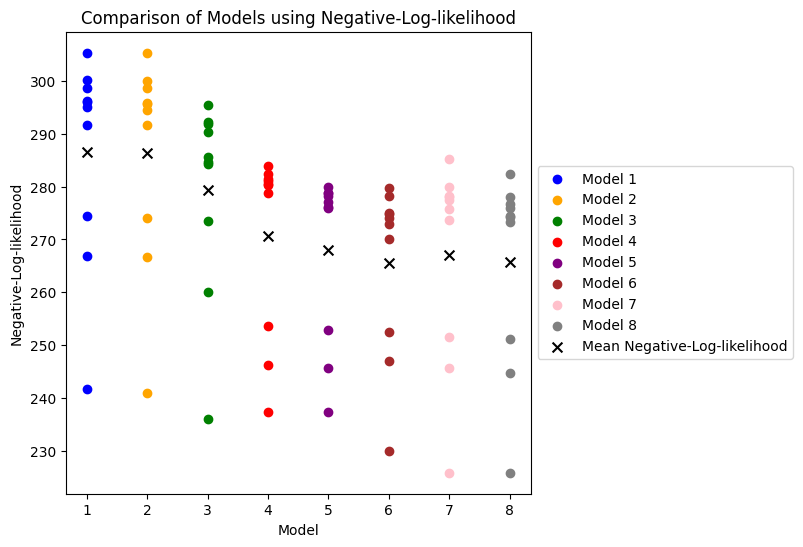

<Figure size 1000x600 with 0 Axes>

In [36]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey']

# Calculate mean log-likelihood for each model
mean_log_likelihoods = [-1*np.mean(list(log_likelihoods[model].values())) for model in log_likelihoods.keys()]

fig, ax = plt.subplots(figsize=(6, 6))

# Create the scatter plot
plt.figure(figsize=(10, 6))
for i, model in enumerate(range(1, 9)):
    y_values = -np.array(list(log_likelihoods[model].values()))
    x_values = [model] * len(y_values)
    ax.scatter(x_values, y_values, color=colors[i], label=f'Model {model}')

# Plot mean log-likelihoods
ax.scatter(list(range(1,9)), mean_log_likelihoods, color='black', marker='x', s=50, label='Mean Negative-Log-likelihood')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Negative-Log-likelihood')
ax.set_title('Comparison of Models using Negative-Log-likelihood')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show();

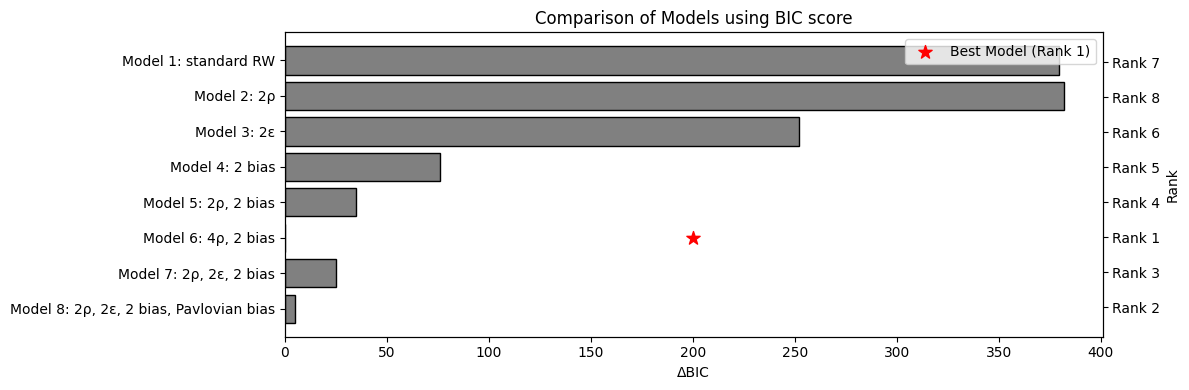

In [40]:
# Models and their descriptions
model_descriptions = [
    "Model 1: standard RW",
    "Model 2: 2ρ",
    "Model 3: 2ε",
    "Model 4: 2 bias",
    "Model 5: 2ρ, 2 bias",
    "Model 6: 4ρ, 2 bias",
    "Model 7: 2ρ, 2ε, 2 bias",
    "Model 8: 2ρ, 2ε, 2 bias, Pavlovian bias",
]

scores = list(BIC_scores.values())
min_score = min(scores)
delta_BIC = [score - min_score for score in scores]
sorted_models = sorted(BIC_scores.items(), key=lambda x: x[1])
model_rank = {model[0]: i+1 for i, model in enumerate(sorted_models)}
ranks = [model_rank[model] for model in BIC_scores.keys()]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Bar plot
y_pos = np.arange(len(delta_BIC))
ax.barh(y_pos, delta_BIC, align="center", color="gray", edgecolor="black")

# Add descriptions and ranks as y-ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(model_descriptions)

# Add ranks on right side of the plot aligned centered with the horizontal bars
ax2 = ax.twinx()
lim = ax.get_ylim()
lim = (lim[0] - 0.07, lim[1] + 0.05)
ax2.set_ylim(lim)
ax2.set_yticks(ticks=[i for i in range(8)], labels=[f"Rank {rank}" for rank in ranks])
ax2.set_ylabel("Rank")
ax2.invert_yaxis()

# Highlight the lowest rank (add a red star)
lowest_rank_index = np.argmin(ranks)
ax.scatter(200, y_pos[lowest_rank_index], color="red", label="Best Model (Rank 1)", marker="*", s=100)


# Add axis labels and title
ax.set_xlabel("ΔBIC")
ax.set_title("Comparison of Models using BIC score")
ax.invert_yaxis()  
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()


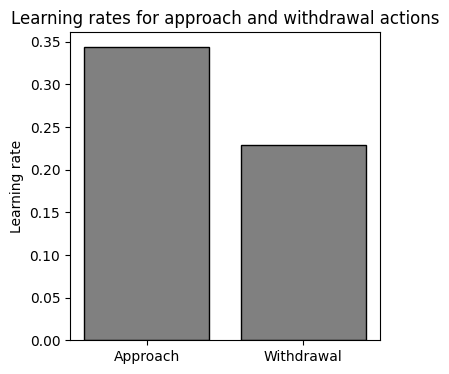

In [56]:
# Comparison of learning rates for approach and withdrawal actions for last model
lr_app = np.mean([subj["lr_app"] for _, subj in best_params_dict[8].items()])
lr_wth = np.mean([subj["lr_wth"] for _, subj in best_params_dict[8].items()])

plt.figure(figsize=(4, 4))
plt.bar(["Approach", "Withdrawal"], [lr_app, lr_wth], color="gray", edgecolor="black")
plt.title("Learning rates for approach and withdrawal actions")
plt.ylabel("Learning rate")
plt.show()

#### Bonus: Fitting first subject 10 times with last model using different intial parameters

In [62]:
# Wrapper function to fit last model on first subject with different initial parameters
def fit_final_model(model_num, data, initial_params, param_bounds):
    # print(f"\nOptimizing Model {model_num}")
    results = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(fit_model_for_subject)(model_num, 1, data, initial_param, param_bounds)
        for initial_param in initial_params
    )
    return [r[1] for r in results] # send back only the parameters

In [84]:
initial_params_list = [{} for _ in range(10)]
# Randomly sample 10 values for each parameter within the bounds
for param, bounds in param_bounds.items():
    param_values = np.linspace(bounds[0], bounds[1], 10)
    np.random.shuffle(param_values)
    for i, value in enumerate(param_values):
        initial_params_list[i][param] = value

In [85]:
fitted_model_params = fit_final_model(8, data, initial_params_list, param_bounds)

In [86]:
bias_app = [params["bias_app"] for params in fitted_model_params]
bias_wth = [params["bias_wth"] for params in fitted_model_params]

In [87]:
bias_app, bias_wth

([np.float64(-3.0),
  np.float64(2.0429677048362547),
  np.float64(2.0429184997389545),
  np.float64(2.04290712837615),
  np.float64(2.042956869638183),
  np.float64(0.5585038289105628),
  np.float64(2.9999992182171136),
  np.float64(3.0),
  np.float64(2.042974382528953),
  np.float64(2.9173379970577384)],
 [np.float64(-0.8760760364181603),
  np.float64(-0.2434624954662276),
  np.float64(-0.24342741147170632),
  np.float64(-0.24348141413735738),
  np.float64(-0.2434427386440157),
  np.float64(-1.5602499657206468),
  np.float64(-3.0),
  np.float64(-3.0),
  np.float64(-0.24341394581223563),
  np.float64(0.021455641470469532)])

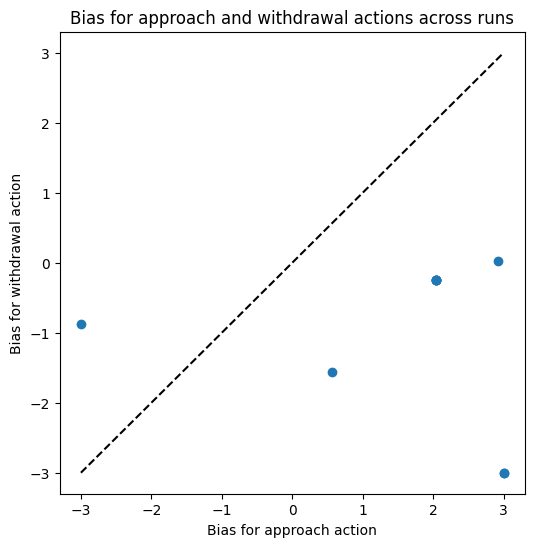

In [88]:
# Make a scatter plot of bias_app and bias_wth and make a y = x line
# For each run, the point has to be labelled with the run number
plt.figure(figsize=(6, 6))
plt.scatter(bias_app, bias_wth)
plt.plot([-3, 3], [-3, 3], color="black", linestyle="--")
plt.xlabel("Bias for approach action")
plt.ylabel("Bias for withdrawal action")
plt.title("Bias for approach and withdrawal actions across runs")
plt.show()